## Panel 1 - The National Landscape

**Takeaway:** Gun violence trends vary sharply by state. Use national trends to set the stage, then show how rates differ across states.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

DATA_DIR = Path('/Users/johnnybae/Documents/Academia/Chaminade/DS495 - Research')
inc = pd.read_csv(DATA_DIR/'Incidents/incidents_all_years.csv.gz', na_values=['N/A'], low_memory=False)
parts = pd.read_csv(DATA_DIR/'Participants/participants_all_years.csv.gz', na_values=['N/A'], low_memory=False)
print(f"Incidents: {len(inc):,} rows | Participants: {len(parts):,} rows")

Incidents: 449,386 rows | Participants: 803,861 rows


### Build incident-level table with `State` and `Year`

I create a compact **ID → (State, Year)** map from participants, then merge once to incidents.

In [2]:
# Keep essentials from participants
need = [c for c in ['ID','State','Date'] if c in parts.columns]
pt = parts[need].copy()

# Robust date parsing
dt = pd.to_datetime(pt['Date'], errors='coerce')
for fmt in ['%d-%b-%y','%Y-%m-%d','%m/%d/%Y','%m/%d/%y']:
    mask = dt.isna()
    if not mask.any(): break
    dt.loc[mask] = pd.to_datetime(pt.loc[mask,'Date'], format=fmt, errors='coerce')
pt['Year'] = pd.to_numeric(dt.dt.year, errors='coerce')

def first_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

id_map = (pt.groupby('ID', as_index=False)
            .agg(State=('State', first_mode), Year=('Year','max')))

for c in ['Vic-Killed','Vic-Injured','Sus-Killed','Sus-Injured','Sus-Unharmed','Sus-Arrested']:
    if c in inc.columns:
        inc[c] = pd.to_numeric(inc[c], errors='coerce')

incidents_enriched = inc.merge(id_map, on='ID', how='left').dropna(subset=['Year'])
incidents_enriched[['ID','State','Year']].head()

/var/folders/vg/b0s2p58n6p14svh9j4syj9r00000gn/T/ipykernel_8470/2211116979.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(pt['Date'], errors='coerce')


,ID,State,Year
0,3040722.0,California,2014.0
1,3040717.0,California,2014.0
2,291511.0,Virginia,2014.0
3,278757.0,Mississippi,2014.0
4,277950.0,Virginia,2014.0


### National trends: incidents & deaths (2014–2024)

Poster figure: **one clean line chart** of incidents and deaths.

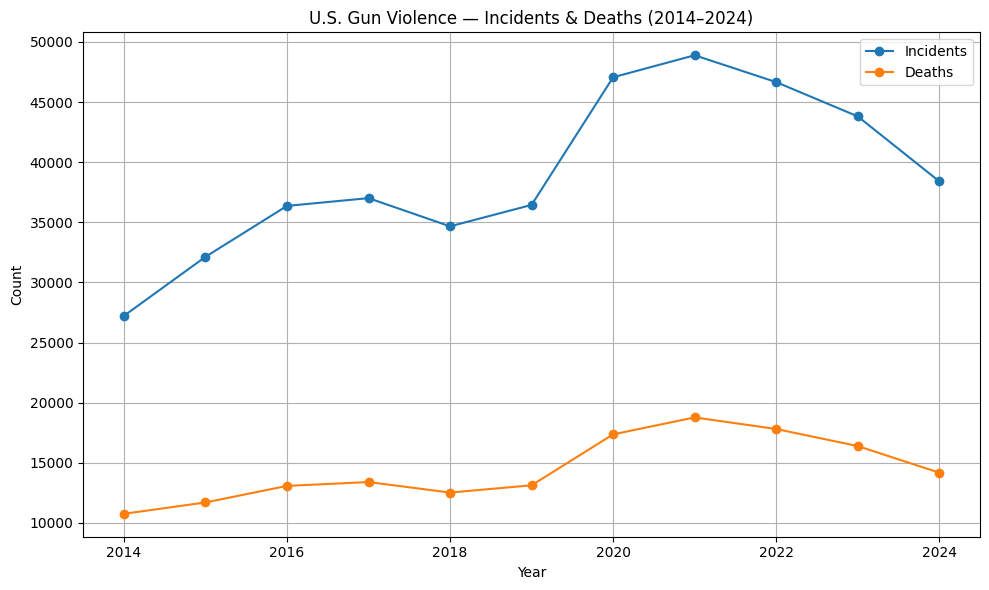

,Year,incidents,victims_killed,victims_injured
6,2020.0,47062,17363.0,37638.0
7,2021.0,48894,18773.0,38747.0
8,2022.0,46661,17809.0,36683.0
9,2023.0,43813,16391.0,34635.0
10,2024.0,38410,14180.0,29923.0


In [3]:
yearly = (incidents_enriched.groupby('Year')
          .agg(incidents=('ID','nunique'),
               victims_killed=('Vic-Killed','sum'),
               victims_injured=('Vic-Injured','sum'))
          .reset_index().sort_values('Year'))

plt.figure(figsize=(10,6))
plt.plot(yearly['Year'], yearly['incidents'], marker='o', label='Incidents')
plt.plot(yearly['Year'], yearly['victims_killed'], marker='o', label='Deaths')
plt.title('U.S. Gun Violence — Incidents & Deaths (2014–2024)')
plt.xlabel('Year'); plt.ylabel('Count'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('panel1_national_trend.png', dpi=300)

plt.show()
yearly.tail()

### (Optional) Top‑10 states by total deaths

Haven't decided: 50‑state population by year choropleth or Compact bar chart.

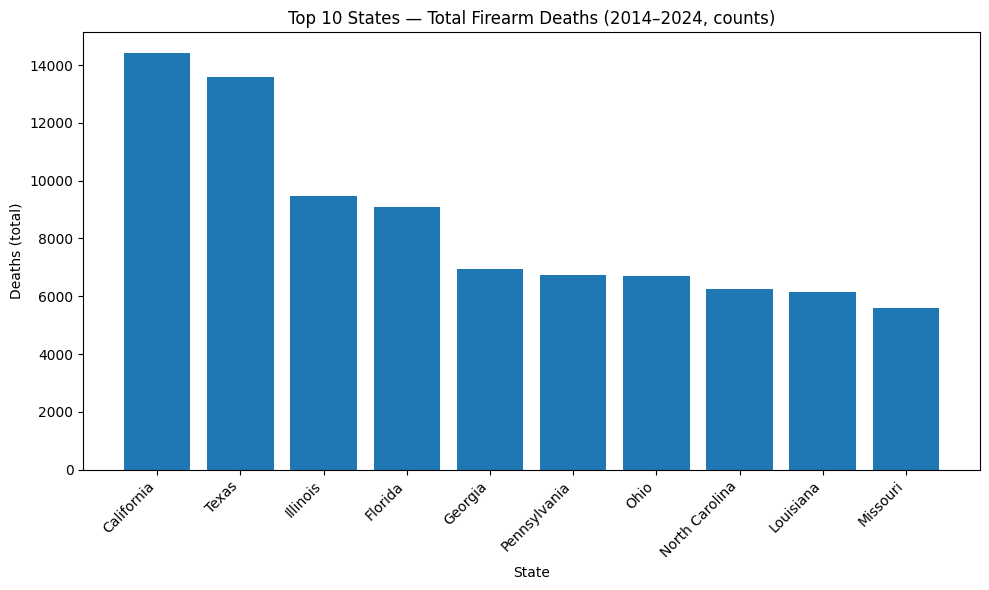

,State,victims_killed
4,California,14415.0
43,Texas,13583.0
13,Illinois,9466.0
9,Florida,9080.0
10,Georgia,6928.0
38,Pennsylvania,6741.0
35,Ohio,6692.0
33,North Carolina,6259.0
18,Louisiana,6141.0
25,Missouri,5606.0


In [4]:
state_totals = (incidents_enriched.groupby('State')
                .agg(victims_killed=('Vic-Killed','sum'))
                .reset_index()
                .sort_values('victims_killed', ascending=False)
                .head(10))

plt.figure(figsize=(10,6))
plt.bar(state_totals['State'], state_totals['victims_killed'])
plt.title('Top 10 States — Total Firearm Deaths (2014–2024, counts)')
plt.xlabel('State'); plt.ylabel('Deaths (total)'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.savefig('panel1_top10_states.png', dpi=300)
plt.show()
state_totals

### Geographic Distribution — Firearm Deaths by State (2014–2024)

To visualize the **spatial pattern of gun violence across the U.S.**, I created a **choropleth map** showing total firearm deaths per state between 2014 and 2024.  
Each state’s color intensity represents the number of victims killed. Darker shades indicate higher totals.


        State  victims_killed
0     Alabama          4986.0
1      Alaska           465.0
2     Arizona          2803.0
3    Arkansas          2044.0
4  California         14415.0


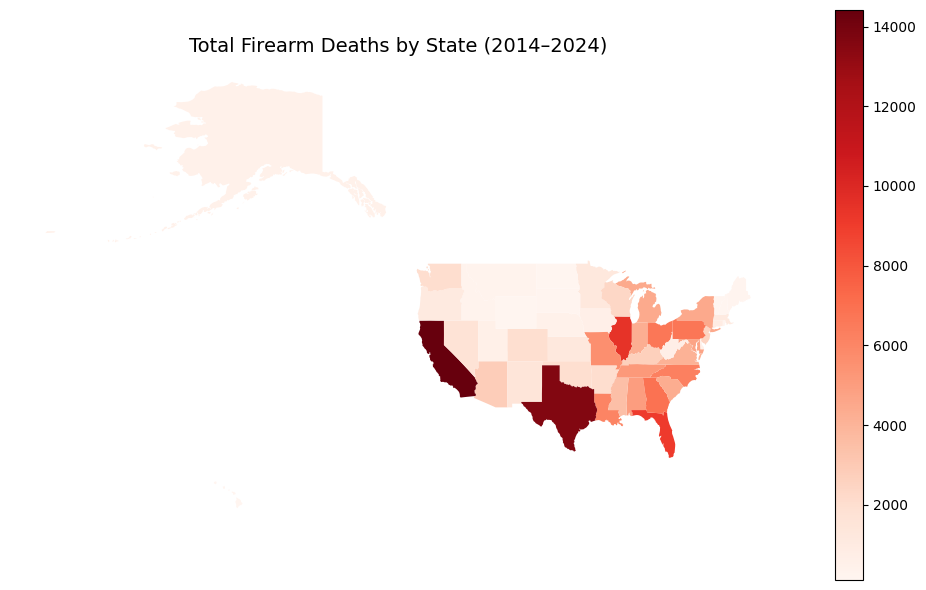

In [5]:
# 1. Load US states shapefile
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# 2. Aggregate state totals (ensure incidents_enriched is already loaded)
state_totals = (
    incidents_enriched.groupby('State')
    .agg(victims_killed=('Vic-Killed','sum'))
    .reset_index()
)

print(state_totals.head())  # <-- sanity check

# 3. Merge with shapefile (state names must match)
us_map = us_map.merge(
    state_totals,
    left_on='name',      # full state names in geojson
    right_on='State',
    how='left'
)

# 4. Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(10,6))
us_map.plot(column='victims_killed', cmap='Reds', legend=True, ax=ax)
ax.set_title('Total Firearm Deaths by State (2014–2024)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig('panel1_choropleth.png', dpi=300)
plt.show()
